# todo:
- add plots titles
- calculate descriptive statistics manually aka pandas .describe() 
- skewness and kurtosis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 1000)

sns.set(style='darkgrid', palette='Set3')

In [3]:
YEARS = [1,2,3,4]

In [4]:
INPUT_PATH = 'data/input'
TRANSFORM_PATH = 'data/transformations'

In [5]:
df = pd.read_csv(f'{TRANSFORM_PATH}/pool.csv')

In [6]:
df = df[df['Курс'].isin(YEARS)]

In [7]:
df.head()

,Курс,Стать,Оцінка з математичої дисципліни,Оцінка з гуманітарної дисципліни,Оцінка з дисципліни за спеціальністю,"1.Коли починаю будь-яку роботу, як правило, сподіваюся на успіх",2.Під час діяльності виявляю активність,3.Маю схильність до виявлення ініціативи,"4.Під час виконання відповідальних завдань намагаюся, якщо це можливо, знайти причини відмовитися від них","5.Часто обираю крайнощі: або надто легкі, або занадто важкі завдання","6.Якщо зустрічаю перешкоди, як правило, не відступаю, а шукаю можливості їх подолання","7.Коли успіхи і невдачі трапляються впереміжку, більше звертаю увагу на успіхи, а невдачами нехтую","8.Коли успіхи і невдачі трапляються впереміжку, більше звертаю увагу на успіхи, а невдачами нехтую","9.Коли завдання складні, а часу мало, результат діяльності погіршується",10.Я зазвичай наполегливий у досягненні мети,11.Планую своє майбутнє на достатньо віддалену перспективу,"12.Якщо ризикую, то скоріше обдумано","13.Не дуже наполегливий у досягненні мети, особливо, якщо відсутній зовнішній контроль","14.Волію ставити перед собою середні або злегка завищені завдання, які реально можу виконати","15.Якщо під час виконання будь-якого завдання мене спіткає невдача, воно стає для мене менш привабливим","16.Коли успіхи і невдачі трапляються впереміжку, більше звертаю уваги на невдачі",17.Планую своє майбутнє лише на найближчий час,"18.Я досягаю кращих результатів, коли час виконання обмежений, навіть якщо завдання досить складне",19.Не відмовляюсь від поставленої мети навіть у разі невдачі під час виконання будь-якої роботи,"20Якщо завдання я обирав сам, тоді у разі невдачі воно ще більше мене приваблює","1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #1","1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #2","1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #3","2.Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. #1","2.Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. #2","2.Предмет, що вивчається, мені цікавий, і я хочу знати якомога більше. #3","3.У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. #1","3.У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. #2","3.У вивчені цього предмета мені достатньо тих знань, які я отримую на заняттях. #3","4.Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. #1","4.Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. #2","4.Навчальні завдання з цього предмета мені нецікаві, я їх виконую, тому що цього вимагає викладач. #3","5.Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. #1","5.Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. #2","5.Труднощі, що виникають при вивченні предмета, роблять його для мене ще більш захопливим. #3",6.При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу #1,6.При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу #2,6.При вивченні предмета крім підручників і рекомендованої літератури я самостійно читаю додаткову літературу #3,"7.Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. #1","7.Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. #2","7.Вважаю, що важкі теоретичні питання з цього предмета можна було б не вивчати. #3","8.Якщо щось не виходить з цього предмета, прагну розібратися і дійти до суті. #1","8.Якщо щось не виходить з цього предмета, прагну розібратися і дійти до суті. #2","8.Якщо щось не виходить з цього предмета, прагну розібратися і дійти до суті. #3","9.На заняттях з цього предмета у мене часто буває такий стан, коли «зовсім не хочеться вчит

In [8]:
df_res = df[[
    'Курс',
    'Стать',
    'Оцінка з математичої дисципліни',
    'Оцінка з гуманітарної дисципліни',
    'Оцінка з дисципліни за спеціальністю']].copy()
# df_res = df[['Курс',
#  'Стать',
#  'Оцінка з організації та обробки електронної інформації',
#  'Оцінка з англійської',
#  'Оцінка з мов програмування']].copy()

# df_res.columns = [
#     'Курс',
#     'Стать',
#     'Оцінка з математичої дисципліни',
#     'Оцінка з гуманітарної дисципліни',
#     'Оцінка з дисципліни за спеціальністю']

# Data preprocessing

### Test 1

In [9]:
start_col = '1.Коли починаю будь-яку роботу, як правило, сподіваюся на успіх'
end_col = '20Якщо завдання я обирав сам, тоді у разі невдачі воно ще більше мене приваблює'
test_cols = df.columns[df.columns.get_loc(start_col):df.columns.get_loc(end_col)+1].tolist()

yes_cols = np.array([1, 2, 3, 6, 8, 10, 11, 12, 14, 16, 18]) - 1
no_cols = np.array([4, 5, 7, 9, 13, 15, 17])-1
point_intervals = {
    (1, 7):  'уникнення невдачі',
    (14, 20): 'досягнення успіху (надія на успіх)',
    (8, 13) : 'полюс не виражений'
}

In [10]:
for col in test_cols:
     df[col] = df[col].map({'так': 1, 'ні':0})

In [11]:
df_res['Тест №1'] = (df[test_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_cols].iloc[:, no_cols]==0).sum(axis=1)

### Test 2

In [12]:
# rename columns for test 2
start_col = '1.Вивчення цього предмета дає мені можливість дізнатися чимало важливого для себе, проявити свої здібності. #1'
end_col = '20.Якби це було можливо, то я виключив цей предмет із розкладу(навчального плану). #3'


# start_col = np.argwhere(df.columns.get_loc(start_col))[0][0]
# end_col = np.argwhere(df.columns.get_loc(end_col))[-1][-1]
# cols = np.array(df.columns)
test_cols = df.columns[df.columns.get_loc(start_col):df.columns.get_loc(end_col)+1].tolist()
# cols[start_col:end_col+1] = [col + ' ' + n for col, n in zip(test_cols, ['#1', '#2', '#3'] * 20)]
# test_cols = cols[start_col:end_col+1].copy()
# df.columns = cols


test_math_cols = [col for col in test_cols if '#1' in col]
test_human_cols = [col for col in test_cols if '#2' in col]
test_prof_cols = [col for col in test_cols if '#3' in col]

yes_cols = np.array([1, 2, 5, 6, 8, 11, 12, 14, 17, 19]) - 1
no_cols = np.array([3, 4, 7, 9, 10, 13, 15, 16, 18, 20]) - 1

point_intervals = {
    (0, 5):  'низький рівень внутрішньої мотивації',
    (6, 14): 'середній рівень внутрішньої мотивації',
    (15, 20): 'високий рівень внутрішньої мотивації'
}

In [13]:
for col in test_cols:
     df[col] = df[col].map({
         '• Вірно':1, '• Напевно, вірно – (+)':1, 
         '• Напевно, невірно – (-);':0, '• Невірно – (- -).' : 0})

In [14]:
df_res['Тест №2.а'] = (df[test_math_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_math_cols].iloc[:, no_cols]==0).sum(axis=1)

df_res['Тест №2.б'] = (df[test_human_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_human_cols].iloc[:, no_cols]==0).sum(axis=1)

df_res['Тест №2.в'] = (df[test_prof_cols].iloc[:, yes_cols]==1).sum(axis=1) \
    + (df[test_prof_cols].iloc[:, no_cols]==0).sum(axis=1)

### Test 3

In [15]:
start_col = '1.Тому що мені подобається обрана професія'
end_col = '34.Бо хочу отримати диплом із гарними оцінками, щоб мати перевагу над іншими.'
test_cols = df.columns[df.columns.get_loc(start_col):df.columns.get_loc(end_col)+1].tolist()

scales = [
    [7, 10, 14, 32],
    [6, 12, 13, 15, 19],
    [8, 9, 29, 30, 34],
    [1, 2, 3, 4, 5, 26],
    [27, 28],
    [17, 18, 20, 21, 22, 23, 24],
    [11, 16, 25, 31, 33]
]

In [16]:
for i, scale in enumerate(scales):
    scale = np.array(scale) - 1
    df_res[f'Тест №3.{i+1}'] = df[test_cols].iloc[:, scale].mean(axis=1)

# Frequancy tables

In [17]:
df_res.head()

,Курс,Стать,Оцінка з математичої дисципліни,Оцінка з гуманітарної дисципліни,Оцінка з дисципліни за спеціальністю,Тест №1,Тест №2.а,Тест №2.б,Тест №2.в,Тест №3.1,Тест №3.2,Тест №3.3,Тест №3.4,Тест №3.5,Тест №3.6,Тест №3.7
0,1,ж,88,100,85,3,10,14,11,4.50,4.8,4.6,4.333333,4.5,4.428571,4.4
1,1,ч,86,98,92,10,11,7,13,4.75,3.6,3.8,3.833333,4.0,4.000000,4.0
2,1,ч,94,95,72,6,10,10,9,4.50,4.8,5.0,5.000000,5.0,4.857143,4.2
3,1,ж,77,75,76,8,10,14,6,4.50,4.4,4.2,4.000000,4.0,4.000000,3.8
4,1,ч,94,92,90,9,12,12,8,3.75,4.0,4.2,4.166667,4.0,4.142857,4.2


In [18]:
bins=3
col = 'Тест №1'
print(pd.cut(df_res[col], bins=bins).value_counts().sort_index())

(2.989, 6.667]      6
(6.667, 10.333]    20
(10.333, 14.0]     22
Name: Тест №1, dtype: int64


In [19]:
bins=4
for col in [
    'Тест №2.а',
    'Тест №2.б',
    'Тест №2.в'
]:
    print(col)
    print(pd.cut(df_res[col], bins=bins).value_counts().sort_index())

Тест №2.а
(0.982, 5.5]     6
(5.5, 10.0]     27
(10.0, 14.5]     9
(14.5, 19.0]     6
Name: Тест №2.а, dtype: int64
Тест №2.б
(0.982, 5.5]     5
(5.5, 10.0]     25
(10.0, 14.5]    12
(14.5, 19.0]     6
Name: Тест №2.б, dtype: int64
Тест №2.в
(0.982, 5.5]     5
(5.5, 10.0]     30
(10.0, 14.5]     9
(14.5, 19.0]     4
Name: Тест №2.в, dtype: int64


In [20]:
bins = int(1+np.log2(df_res.shape[0]))
for col in [
    'Тест №3.1',
    'Тест №3.2',
    'Тест №3.3',
    'Тест №3.4',
    'Тест №3.5',
    'Тест №3.6',
    'Тест №3.7']:
    print(col)
    print(pd.cut(df_res[col], bins=bins).value_counts().sort_index())

Тест №3.1
(2.247, 2.708]     4
(2.708, 3.167]    12
(3.167, 3.625]    17
(3.625, 4.083]     7
(4.083, 4.542]     4
(4.542, 5.0]       4
Name: Тест №3.1, dtype: int64
Тест №3.2
(1.397, 1.967]     2
(1.967, 2.533]     5
(2.533, 3.1]      15
(3.1, 3.667]      17
(3.667, 4.233]     4
(4.233, 4.8]       5
Name: Тест №3.2, dtype: int64
Тест №3.3
(1.797, 2.333]     9
(2.333, 2.867]     8
(2.867, 3.4]      13
(3.4, 3.933]       9
(3.933, 4.467]     5
(4.467, 5.0]       4
Name: Тест №3.3, dtype: int64
Тест №3.4
(0.996, 1.667]     1
(1.667, 2.333]     0
(2.333, 3.0]       2
(3.0, 3.667]      12
(3.667, 4.333]    23
(4.333, 5.0]      10
Name: Тест №3.4, dtype: int64
Тест №3.5
(1.496, 2.083]     1
(2.083, 2.667]     4
(2.667, 3.25]      9
(3.25, 3.833]     12
(3.833, 4.417]    13
(4.417, 5.0]       9
Name: Тест №3.5, dtype: int64
Тест №3.6
(1.711, 2.262]     1
(2.262, 2.81]      5
(2.81, 3.357]     11
(3.357, 3.905]    18
(3.905, 4.452]     9
(4.452, 5.0]       4
Name: Тест №3.6, dtype: int64
Тест

# Graphs

## All years

In [21]:
# df_res['Курс'].value_counts().sort_index()

ж    0.5625
ч    0.4375
Name: Стать, dtype: float64


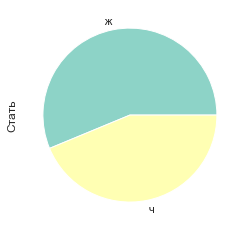

In [22]:
gender = df_res['Стать'].value_counts(normalize=True)
print(gender)
gender.plot(kind='pie');

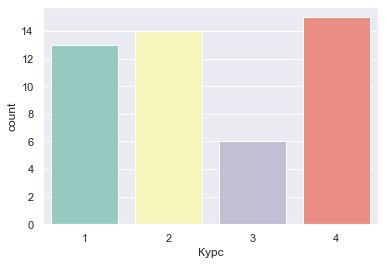

In [23]:
sns.countplot(data=df_res, x = 'Курс')

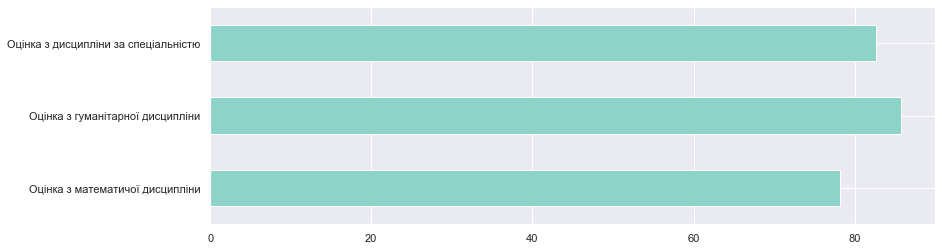

In [24]:
grade_cols = ['Оцінка з математичої дисципліни',
       'Оцінка з гуманітарної дисципліни',
       'Оцінка з дисципліни за спеціальністю']
df_res[grade_cols].mean().plot(kind='barh', figsize=(13, 4))

,Тест №1
count,48.000000
mean,9.708333
std,2.797859
min,3.000000
25%,8.000000
50%,10.000000
75%,12.000000
max,14.000000


No handles with labels found to put in legend.


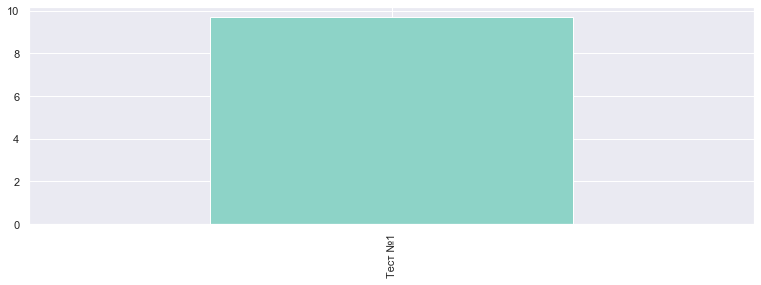

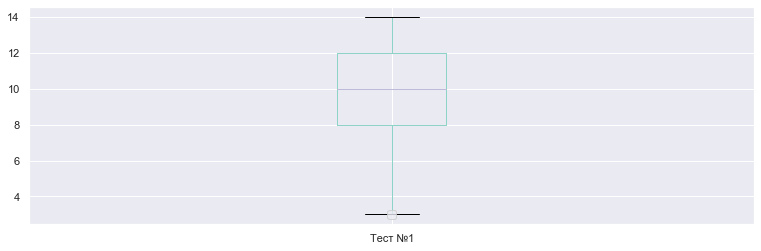

,Тест №2.а,Тест №2.б,Тест №2.в
count,48.000000,48.000000,48.000000
mean,10.000000,10.041667,9.458333
std,3.524987,3.730030,3.566740
min,1.000000,1.000000,1.000000
25%,9.750000,8.000000,8.000000
50%,10.000000,10.000000,10.000000
75%,11.250000,12.000000,11.000000
max,19.000000,19.000000,19.000000


No handles with labels found to put in legend.


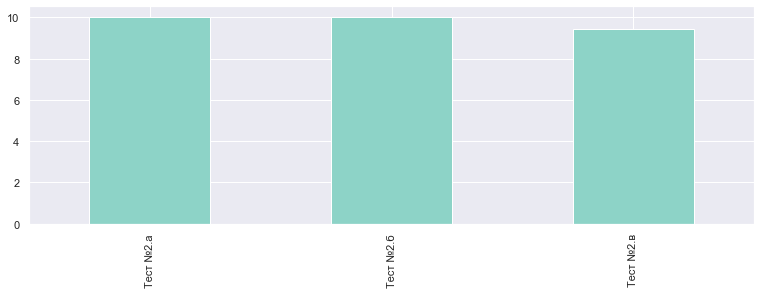

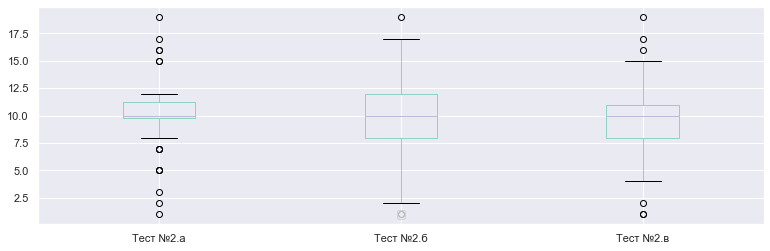

,Тест №3.1,Тест №3.2,Тест №3.3,Тест №3.4,Тест №3.5,Тест №3.6,Тест №3.7
count,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000
mean,3.463542,3.166667,3.195833,3.958333,3.656250,3.526786,3.491667
std,0.699524,0.775512,0.875666,0.723222,0.766008,0.659054,0.669021
min,2.250000,1.400000,1.800000,1.000000,1.500000,1.714286,2.000000
25%,3.000000,2.750000,2.750000,3.666667,3.000000,3.142857,3.000000
50%,3.500000,3.200000,3.100000,4.166667,3.500000,3.428571,3.400000
75%,3.750000,3.600000,3.800000,4.333333,4.000000,4.000000,4.050000
max,5.000000,4.800000,5.000000,5.000000,5.000000,5.000000,5.000000


No handles with labels found to put in legend.


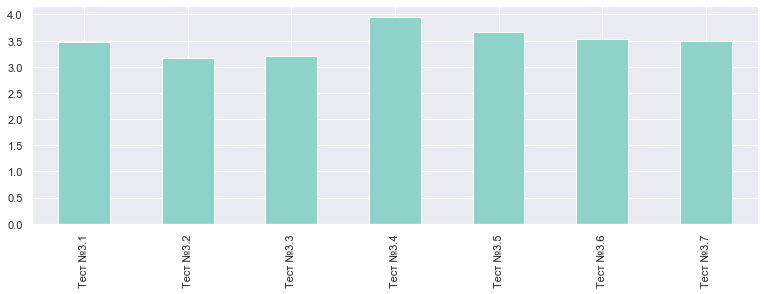

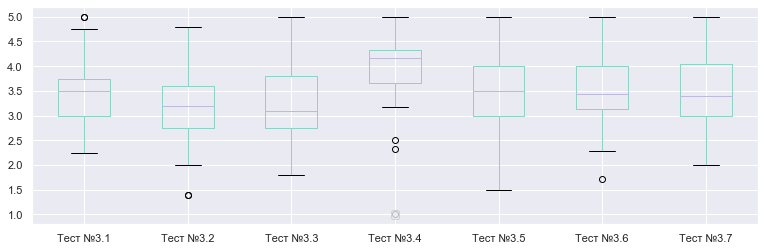

In [25]:
test_cols = [
    ['Тест №1'],
    ['Тест №2.а','Тест №2.б', 'Тест №2.в'],
    ['Тест №3.1', 'Тест №3.2', 'Тест №3.3',
       'Тест №3.4', 'Тест №3.5', 'Тест №3.6', 'Тест №3.7']
]

for t_cols in (test_cols):
    df_res[t_cols].mean().plot(kind='bar', figsize=(13, 4))
    df_res[t_cols].plot(kind='box', figsize=(13, 4))
    display(df_res[t_cols].describe())
    plt.legend(loc='lower center')
    plt.show()
    plt.close()

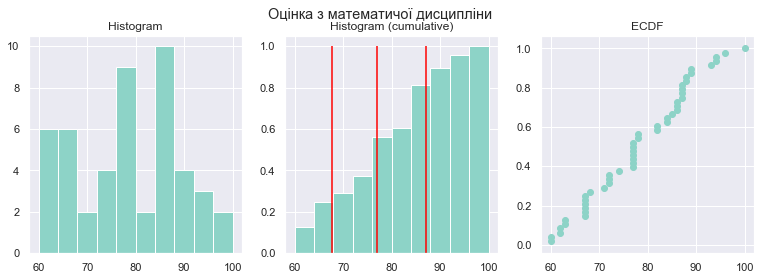

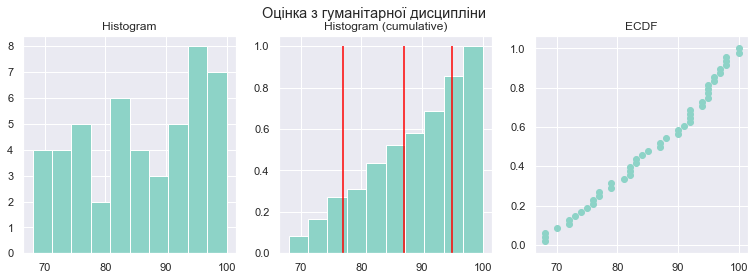

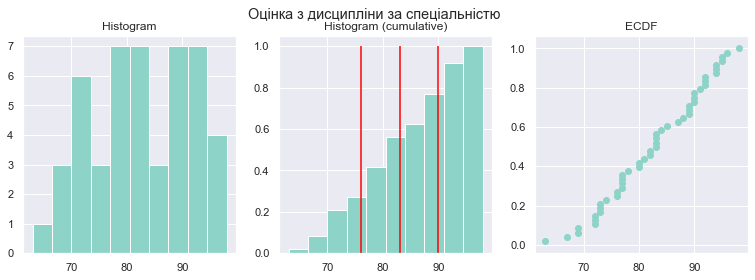

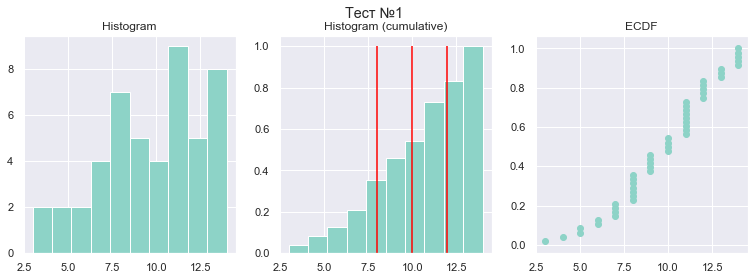

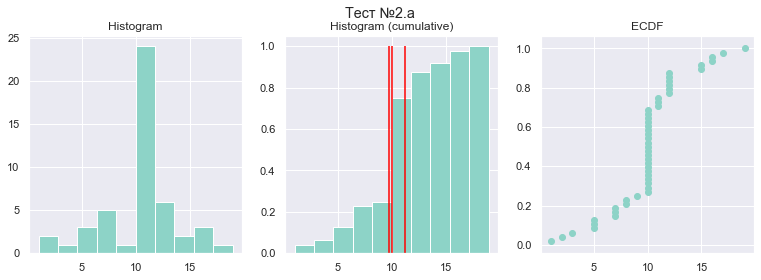

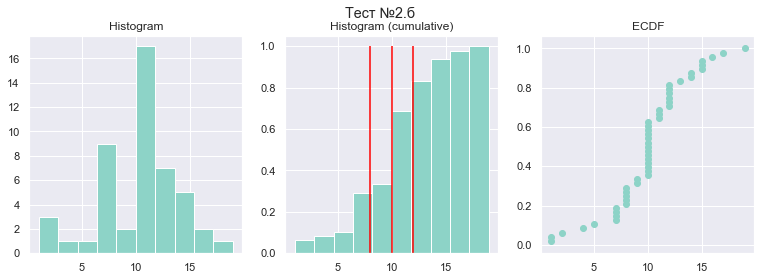

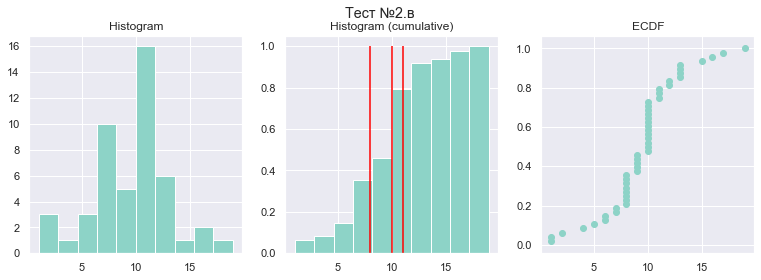

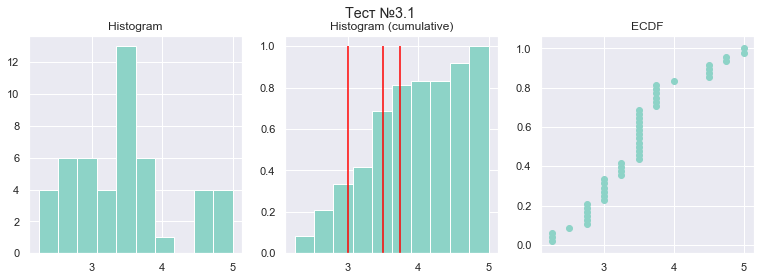

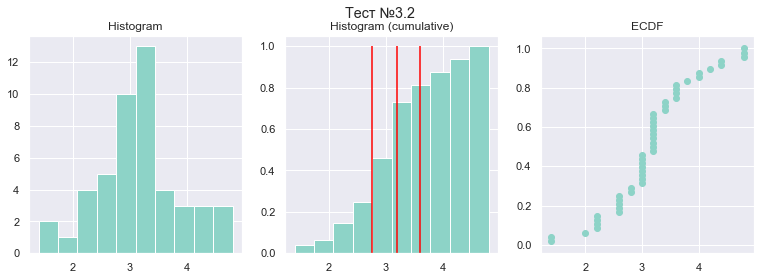

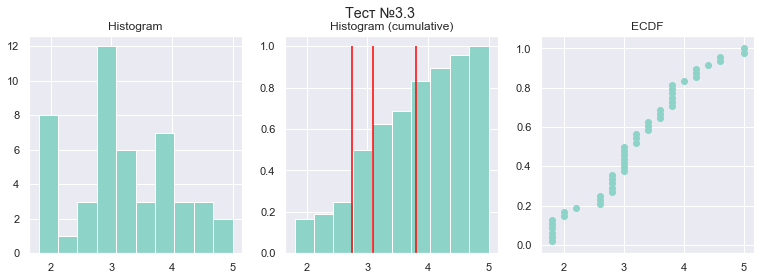

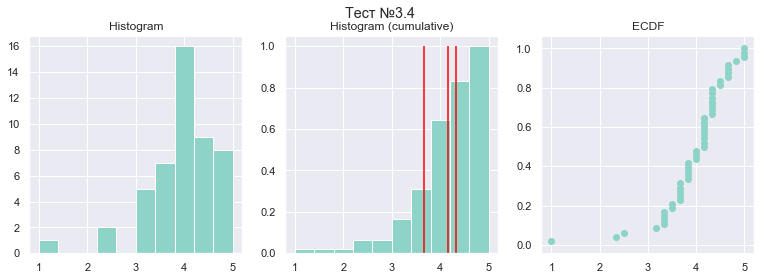

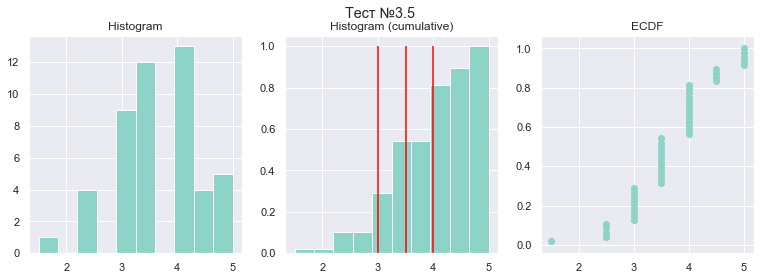

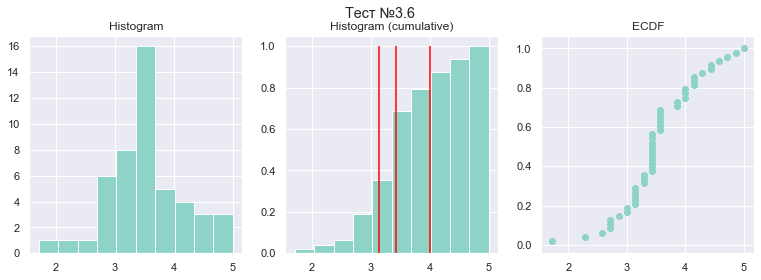

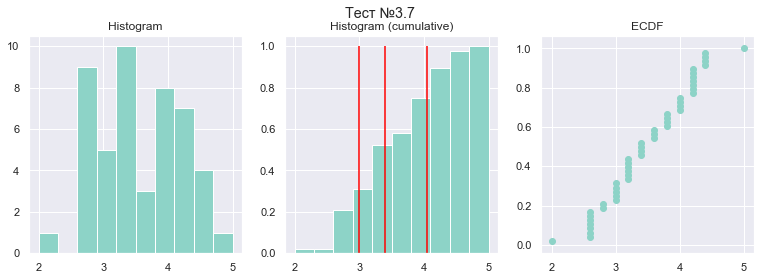

In [26]:
bins = 4

for col in df_res.columns:
    if col in ['Курс', 'Стать']:
        continue
    fig, ax = plt.subplots(1,3, figsize=(13, 4))
    df_res[col].hist(ax = ax[0])
    ax[0].set_title('Histogram')
    
    df_res[col].hist(ax = ax[1], cumulative=True, density=True)
    ax[1].set_title('Histogram (cumulative)')
    
    n =df_res[col].shape[0]
    ax[2].scatter(np.sort(df_res[col]), np.arange(1, n+1) / n)
    ax[2].set_title('ECDF')
    
    
    percentiles = np.percentile(df_res[col], [25, 50, 75])
    ax[1].vlines(percentiles, ymin=0, ymax=1, color='r')
    
    plt.suptitle(col)
    plt.show()
    plt.close()

## By years

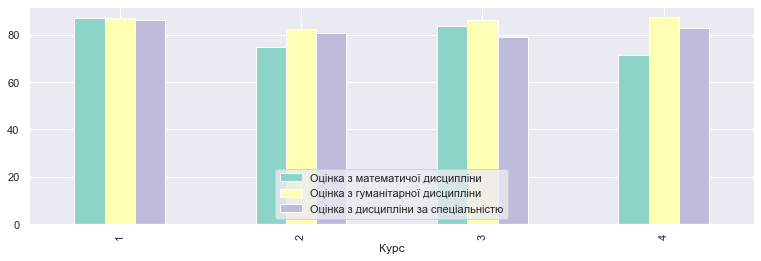

In [27]:
# df_res = df_res.loc[:,~df_res.columns.duplicated()]
grade_cols = ['Оцінка з математичої дисципліни',
       'Оцінка з гуманітарної дисципліни',
       'Оцінка з дисципліни за спеціальністю']
df_res.groupby(['Курс'])[grade_cols].mean().plot(kind='bar', figsize=(13, 4))
plt.legend(loc='lower center')

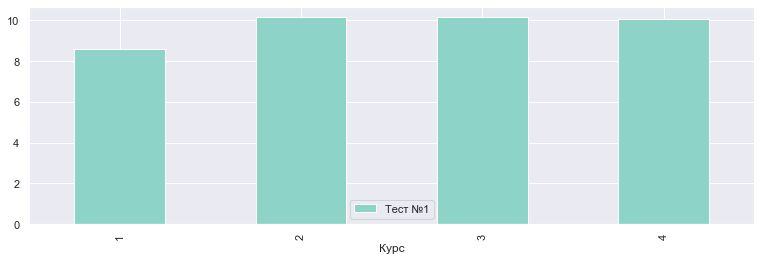

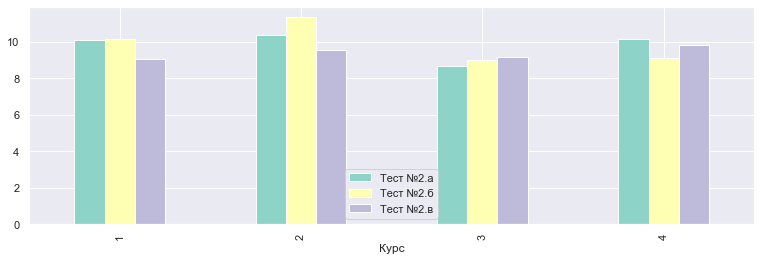

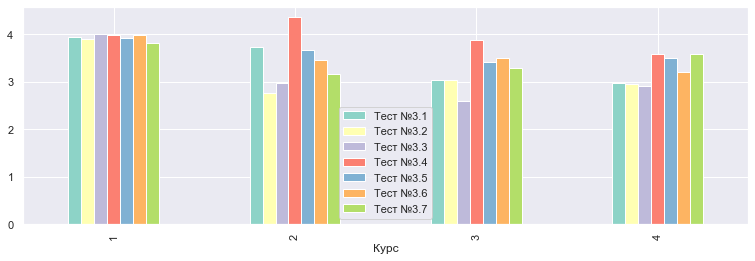

In [28]:
test_cols = [
    ['Тест №1'],
    ['Тест №2.а','Тест №2.б', 'Тест №2.в'],
    ['Тест №3.1', 'Тест №3.2', 'Тест №3.3',
       'Тест №3.4', 'Тест №3.5', 'Тест №3.6', 'Тест №3.7']
]
for t_cols in (test_cols):
    df_res.groupby(['Курс'])[t_cols].mean().plot(kind='bar', figsize=(13, 4))
    plt.legend(loc='lower center')
    plt.show()
    plt.close()

In [29]:
df_res.to_excel(f'{TRANSFORM_PATH}/tests results.xlsx', index=False)